# Table of Contents

1. [Global parameters](#1-bullet) <br>
    <br>
    
2. [Loading datas](#2-bullet) <br>
    <br>

3. [Preprocessing](#3-bullet) <br>
    I - [Cleaning](#4-bullet) <br>
    II - [Split train/test and preprocessing](#5-bullet) <br>
    III - [Dimensionality reduction](#6-bullet) <br>
    IV - [Creation of folds for cv](#7-bullet) <br>
    <br>

4. [Baseline model testing](#8-bullet) <br>
    I - [Dummy classifiers ](#9-bullet) <br>
    II - [Quick testing](#10-bullet) <br>
    <br>

5. [Cross-validation model testing](#11-bullet) <br>
    I - [Linear models](#12-bullet) <br>
    II - [KNN](#13-bullet) <br>
    III - [SVM](#14-bullet) <br>
    IV - [Trees and ensemblist methods](#15-bullet) <br>
    V - [Neural networks](#16-bullet) <br>
    VI - [Compare](#17-bullet) <br>
    <br>
    
6. [Selected model fine tuning](#18-bullet) <br>
    I - [Fine tuning](#19-bullet) <br>
    II - [Business optimization](#20-bullet) <br>
    III - [Features importance](#21-bullet) <br>
    IV - [Train on full dataset and save model](#22-bullet) <br>
    <br>

# 1. Global parameters <a class="anchor" id="1-bullet"></a>

In [54]:
# General input
random_state = 50 

# Cross-validation
optimized_metric = 'roc_auc' 
num_folds = 5
stratified = True

# 2. Loading datas <a class="anchor" id="2-bullet"></a>

In [55]:
import torch

In [56]:
# Classic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import timeit
import pickle
from contextlib import contextmanager
from collections import Counter

import warnings
from pandas.core.common import SettingWithCopyWarning
# warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

# Project specific functions
from P7_functions import *

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn import manifold, decomposition
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import imblearn

# Sklearn models
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Neural networks
import tensorflow as tf

# Evaluation
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal
from sklearn.dummy import DummyClassifier
import shap

In [57]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [58]:
baseline_data = pd.read_csv('./Clean_datas/baseline_data.csv', sep=",")
data = pd.read_csv('./Clean_datas/clean_data_1.csv', sep=",")

In [59]:
data.head()

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,CURRENT_LOAN_LTV,CURRENT_LOAN_INCOME_CREDIT_PERC,CURRENT_LOAN_PAYMENT_RATE,TOTAL_AMT_ANNUITY,TOTAL_AMT_CREDIT,TOTAL_EFFORT_RATE,TOTAL_INCOME_CREDIT_PERC,TOTAL_PAYMENT_RATE,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON
0,0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,...,1.158397,0.498036,0.060749,247829.081500,888586.065,1.223847,0.227890,0.278903,0.067329,202500.0
1,1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,...,1.145199,0.208736,0.027598,292122.185803,2103502.500,1.081934,0.128357,0.138874,0.070862,135000.0
2,2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,...,1.000000,0.500000,0.050000,NaN,NaN,NaN,NaN,NaN,0.011814,67500.0
3,3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,...,1.052803,0.431748,0.094941,NaN,NaN,NaN,NaN,NaN,0.159905,67500.0
4,4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,...,1.000000,0.236842,0.042623,NaN,NaN,NaN,NaN,NaN,0.152418,121500.0


In [60]:
data.drop(['Unnamed: 0', 'SK_ID_CURR'], axis=1, inplace=True)

In [61]:
y = data['TARGET']
x = data.drop(['TARGET'], axis=1)
baseline_y = baseline_data['TARGET']
baseline_x = baseline_data.drop(['TARGET'], axis=1) # Note : categorical data already encoded

In [62]:
print(x.shape)
print(y.shape)

(307507, 399)
(307507,)


In [63]:
# Look targets breakdown
y.value_counts().apply(lambda x: x / y.count())

0    0.91927
1    0.08073
Name: TARGET, dtype: float64

We have very imbalanced classes, we will use StratifiedKFold for now. And see for SMOTE after

# 3. Preprocessing <a class="anchor" id="3-bullet"></a>

## I - Cleaning <a class="anchor" id="4-bullet"></a>

In [64]:
x.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,CURRENT_LOAN_LTV,CURRENT_LOAN_INCOME_CREDIT_PERC,CURRENT_LOAN_PAYMENT_RATE,TOTAL_AMT_ANNUITY,TOTAL_AMT_CREDIT,TOTAL_EFFORT_RATE,TOTAL_INCOME_CREDIT_PERC,TOTAL_PAYMENT_RATE,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON
count,307507.000000,3.075070e+05,3.075070e+05,307495.000000,3.072290e+05,307507.000000,307507.000000,252133.000000,307507.000000,307507.000000,...,307229.000000,307507.000000,307495.000000,2.163040e+05,2.163140e+05,216304.000000,216314.000000,216304.000000,252133.000000,3.075050e+05
mean,0.417047,1.687977e+05,5.990286e+05,27108.666786,5.383977e+05,0.020868,-16037.027271,-2384.142254,-4986.131376,-2994.201670,...,1.122994,0.399669,0.053695,9.411559e+05,1.926691e+06,5.708165,0.154313,0.609689,0.156860,9.310608e+04
std,0.722119,2.371246e+05,4.024926e+05,14493.798379,3.694472e+05,0.013831,4363.982424,2338.327666,3522.883030,1509.454566,...,0.124036,0.507927,0.022481,5.921754e+06,2.459518e+06,33.373152,0.246091,3.542178,0.133548,1.013739e+05
min,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,...,0.150000,0.011801,0.022073,3.006000e+03,4.500000e+04,0.003830,0.000603,0.001404,-0.000000,2.812500e+03
25%,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-3175.000000,-7479.500000,-4299.000000,...,1.000000,0.193802,0.036900,9.718556e+04,7.524000e+05,0.640621,0.072865,0.093214,0.056098,4.725000e+04
50%,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1648.000000,-4504.000000,-3254.000000,...,1.118800,0.306272,0.050000,3.004183e+05,1.305000e+06,2.029257,0.116145,0.211615,0.118733,7.500000e+04
75%,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-767.000000,-2010.000000,-1720.000000,...,1.198000,0.495376,0.064043,7.142913e+05,2.254457e+06,4.373481,0.189675,0.395364,0.219167,1.125000e+05
max,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,0.000000,0.000000,0.000000,...,6.000000,208.003328,0.124430,6.802079e+08,3.356847e+08,3702.839475,95.097017,264.392053,0.728811,3.900000e+07


In [65]:
# Defining numerical and categorical columns
categorical_cols = [col for col in x.columns if x[col].dtype == 'object']
numerical_cols = list(x.drop(categorical_cols, axis=1).columns)

In [66]:
# Checking infinite values
  
count = np.isinf(x[numerical_cols]).values.sum()
print("The df contains " + str(count) + " infinite values")

The df contains 8877 infinite values


In [67]:
# We replace inf values by NaN
x.replace([np.inf, -np.inf], np.nan, inplace=True)

## II - Split train/test and preprocessing <a class="anchor" id="5-bullet"></a>

In [68]:
# Split between train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=random_state)

In [69]:
# Definition of preprocessing steps

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('stdscaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [70]:
# Preprocess datas
x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)

## III - Dimensionality reduction <a class="anchor" id="6-bullet"></a>

To speed up our algorithms on our model selection, we will reduce the dimensionality of our dataset 

In [71]:
# PCA on processed data

print("Dimensions x_train before PCA reduction : ", x_train_processed.shape)
print("Dimensions x_test before PCA reduction : ", x_test_processed.shape)
pca = decomposition.PCA(n_components=0.99)

print("")
with timer("Proceed PCA on train and test set"):
    x_train_pca = pca.fit_transform(x_train_processed)
    x_test_pca = pca.transform(x_test_processed)

print("Dimensions x_train after PCA reduction : ", x_train_pca.shape)
print("Dimensions x_test after PCA reduction : ", x_test_pca.shape)

Dimensions x_train before PCA reduction :  (246005, 670)
Dimensions x_test before PCA reduction :  (61502, 670)

Proceed PCA on train and test set - done in 25s
Dimensions x_train after PCA reduction :  (246005, 289)
Dimensions x_test after PCA reduction :  (61502, 289)


## IV - Creation of folds for cv <a class="anchor" id="7-bullet"></a>

In [72]:
folds = create_folds(x_train_pca, y_train, num_folds=num_folds, stratified=True, random_state=random_state)

In [73]:
# Look classs balance in each fold

for i in range(5):
   print(Counter(y_train.iloc[folds[i][1]]))

Counter({0: 45234, 1: 3967})
Counter({0: 45234, 1: 3967})
Counter({0: 45233, 1: 3968})
Counter({0: 45233, 1: 3968})
Counter({0: 45233, 1: 3968})


# 4. Baseline model testing <a class="anchor" id="8-bullet"></a>

## I - Dummy classifiers <a class="anchor" id="9-bullet"></a>

### a. Unbalanced

In [220]:
dummies = test_dummy_classifiers(x_train_pca, y_train, valid_size=0.2, 
                                 strategies_list=None, random_state=random_state, constant=0, balance_class=False)
dummies

,most_frequent,prior,stratified,uniform,constant
accuracy,0.919981,0.919981,0.853194,0.500376,0.919981
f1,0.000000,0.000000,0.079521,0.136565,0.000000
precision,0.000000,0.000000,0.079795,0.079240,0.000000
recall,0.000000,0.000000,0.079248,0.493777,0.000000
roc_auc,0.500000,0.500000,0.499879,0.500000,0.500000
cross_entropy,2.763748,2.763748,5.070557,17.256768,2.763748
fit_time,0.016626,0.014415,0.008039,0.012216,0.013446
predict_time,0.001482,0.000999,0.001896,0.001412,0.000870


In [221]:
print("Average roc_auc : {:.6f}".format(dummies.iloc[4].mean()))

Average roc_auc : 0.499976


### b. Balanced

In [255]:
dummies_2 = test_dummy_classifiers(x_train_pca, y_train, valid_size=0.2, 
                                   strategies_list=None, random_state=random_state, constant=0, balance_class=True)
dummies_2

,most_frequent,prior,stratified,uniform,constant
accuracy,0.919981,0.919981,0.642914,0.500376,0.919981
f1,0.000000,0.000000,0.128392,0.136565,0.000000
precision,0.000000,0.000000,0.079778,0.079240,0.000000
recall,0.000000,0.000000,0.328677,0.493777,0.000000
roc_auc,0.500000,0.500000,0.499461,0.500000,0.500000
cross_entropy,2.763748,2.763748,12.333564,17.256768,2.763748
fit_time,0.006022,0.001100,0.000928,0.001024,0.001601
predict_time,0.001698,0.000466,0.001782,0.000491,0.000528


In [256]:
print("Average roc_auc : {:.6f}".format(dummies_2.iloc[4].mean()))

Average roc_auc : 0.499892


## II - Quick testing <a class="anchor" id="10-bullet"></a>

### a. Unbalanced

In [271]:
# Test some models without hyperparameters optimization

models_list = [
    # 'GradientBoostingClassifier', 
    'RandomForestClassifier', 
    'KNeighborsClassifier',
    # 'GaussianProcessClassifier', 
    'LogisticRegression', 
    'RidgeClassifier', 
    # 'SGDClassifier',
    # 'LinearSVC', 
    # 'NuSVC', 
    'SVC', 
    # 'DecisionTreeClassifier'
]

with timer("Quick test of some classifiers"):
    quick_test_1 = quick_classifiers_test(x_train_pca, y_train, valid_size=0.2,models_list=models_list, 
                                          random_state=random_state, max_iter=10000, n_jobs=-1, balance_class=False)

quick_test_1

Quick test of some classifiers - done in 22795s


C:\Users\robin\anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,RandomForestClassifier,KNeighborsClassifier,LogisticRegression,RidgeClassifier,SVC
accuracy,0.919798,0.915103,0.920063,0.919981,0.919981
f1,0.000507,0.045693,0.055249,0.001015,0.000000
precision,0.090909,0.227273,0.508850,0.500000,0.000000
recall,0.000254,0.025400,0.029210,0.000508,0.000000
roc_auc,0.662433,0.577950,0.771007,0.767978,0.673001
cross_entropy,2.770066,2.932232,2.760942,2.763748,2.763748
fit_time,422.415992,0.126682,123.843777,0.732317,20675.629150
predict_time,1.262353,41.642139,0.040803,0.019151,743.403910
compute_score_time,0.070560,0.047518,0.046990,0.040441,0.045043


In [272]:
print("Average roc_auc : {:.6f}".format(quick_test_1.iloc[4].mean()))
print("Max roc_auc : {:.6f}".format(quick_test_1.iloc[4].max()))

Average roc_auc : 0.690474
Max roc_auc : 0.771007


### b. Balanced

In [262]:
with timer("Quick test of some classifiers"):
    quick_test_2 = quick_classifiers_test(x_train_pca, y_train, valid_size=0.2,models_list=models_list, 
                                          random_state=random_state, max_iter=10000, n_jobs=-1, balance_class=True)

quick_test_2

Quick test of some classifiers - done in 1464s


,RandomForestClassifier,KNeighborsClassifier,LogisticRegression,RidgeClassifier,SVC
accuracy,0.895043,0.687974,0.841345,0.848641,0.859962
f1,0.193629,0.194628,0.310668,0.311547,0.312101
precision,0.251317,0.122645,0.238121,0.244913,0.257115
recall,0.157480,0.471171,0.446787,0.427991,0.397003
roc_auc,0.714894,0.622611,0.770914,0.770269,0.763111
cross_entropy,3.625124,10.777218,5.479852,5.227829,4.836808
fit_time,60.890628,0.019599,18.908819,0.173946,584.349935
predict_time,0.926250,11.538366,0.018744,0.018717,386.572186
compute_score_time,0.036803,0.049717,0.037641,0.041494,0.055558


In [270]:
print("Average roc_auc : {:.6f}".format(quick_test_2.iloc[4].mean()))
print("Max roc_auc : {:.6f}".format(quick_test_2.iloc[4].max()))

Average roc_auc : 0.728360
Max roc_auc : 0.770914


Balancing seems to improve our performances, we will apply it on further testing

In [21]:
balance_class = True

# 5. Cross-validation model testing <a class="anchor" id="11-bullet"></a>

## I - Linear models <a class="anchor" id="12-bullet"></a>

In [265]:
# RidgeClassifier

model = RidgeClassifier(random_state=random_state, max_iter=10000)
param_grid = {'alpha' : np.linspace(1, 10, num=4, dtype=int)}

with timer("Proceed RidgeClassifier"):
    RidgeClassifier_clf = run_GridSearchCV(model, x_train_pca, y_train, folds, 
                                           param_grid, optimized_metric, balance_class=balance_class)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters on training set :
{'model__alpha': 10}
Best score on training set : 0.768
Proceed RidgeClassifier - done in 31s


## II - KNN <a class="anchor" id="13-bullet"></a>

In [268]:
# KNeighborsClassifier

model = KNeighborsClassifier()
param_grid = {'n_neighbors' : np.linspace(3, 10, num=4, dtype=int)}

with timer("Proceed KNeighborsClassifier"):
    KNeighborsClassifier_clf = run_GridSearchCV(model, x_train_pca, y_train, folds, 
                                                param_grid, optimized_metric, balance_class=balance_class)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters on training set :
{'model__n_neighbors': 10}
Best score on training set : 0.646
Proceed KNeighborsClassifier - done in 215s


## III - SVM <a class="anchor" id="14-bullet"></a>

In [269]:
# LinearSVC

model = LinearSVC(random_state=random_state, max_iter=10000)
param_grid = {'C' : np.linspace(0.1, 1, num=4)}

with timer("Proceed LinearSVC"):
    LinearSVC_clf = run_GridSearchCV(model, x_train_pca, y_train, folds, 
                                     param_grid, optimized_metric, balance_class=balance_class)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters on training set :
{'model__C': 0.1}
Best score on training set : 0.768
Proceed LinearSVC - done in 2628s


C:\Users\robin\anaconda3\envs\fastai\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [273]:
# SVC

model = SVC(kernel='rbf', random_state=random_state, max_iter=10000)
param_grid = {'C' : np.linspace(0.1, 1, num=4)}

with timer("Proceed SVC"):
    SVC_clf = run_GridSearchCV(model, x_train_pca, y_train, folds, 
                               param_grid, optimized_metric, balance_class=balance_class)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters on training set :
{'model__C': 0.4}
Best score on training set : 0.685
Proceed SVC - done in 3122s


C:\Users\robin\anaconda3\envs\fastai\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


## IV - Trees and ensemblist methods <a class="anchor" id="15-bullet"></a>

In [274]:
# DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=random_state)
param_grid = {'min_samples_split' : [2, 8], 'min_samples_leaf' : [1, 5]}

with timer("Proceed DecisionTreeClassifier"):
    DecisionTreeClassifier_clf = run_GridSearchCV(model, x_train_pca, y_train, folds, 
                                                  param_grid, optimized_metric, balance_class=balance_class)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters on training set :
{'model__min_samples_leaf': 5, 'model__min_samples_split': 2}
Best score on training set : 0.575
Proceed DecisionTreeClassifier - done in 177s


In [25]:
# GradientBoostingClassifier --> not tested in 2nd iteration (too long to train, 43891s iteration 1)

# model = GradientBoostingClassifier(random_state=random_state)
# param_grid = {'n_estimators' : [10, 100, 500]}

# with timer("Proceed GradientBoostingClassifier"):
    # GradientBoostingClassifier_clf = run_GridSearchCV(model, x_train_pca, y_train, folds, 
                                                      # param_grid, optimized_metric, balance_class=balance_class)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters on training set :
{'n_estimators': 500}
Best score on training set : 0.760
Proceed GradientBoostingClassifier - done in 43891s


In [275]:
# RandomForestClassifier

model = RandomForestClassifier(random_state=random_state)
param_grid = {'n_estimators' : [10, 500]}

with timer("Proceed RandomForestClassifier"):
    RandomForestClassifier_clf = run_GridSearchCV(model, x_train_pca, y_train, folds, 
                                                  param_grid, optimized_metric, balance_class=balance_class)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters on training set :
{'model__n_estimators': 500}
Best score on training set : 0.729
Proceed RandomForestClassifier - done in 1642s


## V - Neural networks <a class="anchor" id="16-bullet"></a>

In [286]:
# We will test a standard binary classification NN model (activations hidden = relu, last activation = sigmoid) 
# and try to optimize hyperparameters (learning rate, nb neurons and layers)

def build_model(n_hidden=1, n_neurons=30, learning_rate=0.001, input_shape=[289]):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["AUC"])
    return model

In [287]:
keras_clf = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [288]:
# Testing hyperparameters

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.linspace(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2)
}

# Testing model parameters
nn_clf = RandomizedSearchCV(keras_clf, param_distribs, n_iter=10, 
                            cv=folds, scoring=optimized_metric, random_state=random_state)

with timer("Proceed NeuralNetwork"):
    nn_clf.fit(x_train_pca, y_train, epochs=10, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)])

Epoch 1/10
6151/6151 [==============================] - 10s 925us/step - loss: 0.2899 - auc: 0.5990
Epoch 2/10
6151/6151 [==============================] - 6s 897us/step - loss: 0.2634 - auc: 0.7017
Epoch 3/10
6151/6151 [==============================] - 6s 904us/step - loss: 0.2540 - auc: 0.7344
Epoch 4/10
6151/6151 [==============================] - 6s 906us/step - loss: 0.2496 - auc: 0.7489
Epoch 5/10
6151/6151 [==============================] - 6s 899us/step - loss: 0.2471 - auc: 0.7569
Epoch 6/10
6151/6151 [==============================] - 6s 911us/step - loss: 0.2453 - auc: 0.7625
Epoch 7/10
6151/6151 [==============================] - 6s 898us/step - loss: 0.2439 - auc: 0.7670
Epoch 8/10
6151/6151 [==============================] - 6s 898us/step - loss: 0.2427 - auc: 0.7705
Epoch 9/10
6151/6151 [==============================] - 6s 905us/step - loss: 0.2417 - auc: 0.7734
Epoch 10/10
6151/6151 [==============================] - 6s 895us/step - loss: 0.2409 - auc: 0.7758
Epoch 1/

In [289]:
print("Best parameters on training set :")
print(nn_clf.best_params_)
print("Best score on training set : {:.3f}".format(nn_clf.best_score_))

Best parameters on training set :
{'learning_rate': 0.0009729020135732503, 'n_hidden': 0, 'n_neurons': 13.122448979591836}
Best score on training set : 0.764


## VI - Compare <a class="anchor" id="17-bullet"></a>

In [290]:
# Compare scores in this iteration

cv_clfs = {
    'LogisticRegression' : LogisticRegression_clf,
    'RidgeClassifier' : RidgeClassifier_clf,
    'KNeighborsClassifier' : KNeighborsClassifier_clf,
    'LinearSVC' : LinearSVC_clf,
    'SVC' : SVC_clf,
    'DecisionTreeClassifier' : DecisionTreeClassifier_clf,
    # 'GradientBoostingClassifier' : GradientBoostingClassifier_clf,
    'RandomForestClassifier' : RandomForestClassifier_clf,
    'NeuralNetwork' : nn_clf,
}

iteration_2 = pd.DataFrame()

for key, clf in cv_clfs.items():
    iteration_2[key] = [clf.best_score_, clf.best_params_]
    
iteration_2.index = ['best_score_ : ' + optimized_metric, 'best_params_']

In [291]:
iteration_2

,LogisticRegression,RidgeClassifier,KNeighborsClassifier,LinearSVC,SVC,DecisionTreeClassifier,RandomForestClassifier,NeuralNetwork
best_score_ : roc_auc,0.768028,0.767798,0.645989,0.768115,0.685251,0.575201,0.728944,0.763832
best_params_,{'model__C': 1.0},{'model__alpha': 10},{'model__n_neighbors': 10},{'model__C': 0.1},{'model__C': 0.4},"{'model__min_samples_leaf': 5, 'model__min_samples_split': 2}",{'model__n_estimators': 500},"{'learning_rate': 0.0009729020135732503, 'n_hidden': 0, 'n_neurons': 13.122448979591836}"


In [292]:
iteration_2.iloc[0].sort_values(ascending=False)

LinearSVC                 0.768115
LogisticRegression        0.768028
RidgeClassifier           0.767798
NeuralNetwork             0.763832
RandomForestClassifier    0.728944
SVC                       0.685251
KNeighborsClassifier      0.645989
DecisionTreeClassifier    0.575201
Name: best_score_ : roc_auc, dtype: object

In [293]:
iteration_2.to_csv('./Scores/iteration_2.csv')

Logistic regression has almost the best performance and is much faster to train than LinearSVC so we will choose this algorithm

# 6. Selected model fine tuning and interpretation <a class="anchor" id="18-bullet"></a>

## I - Fine tuning <a class="anchor" id="19-bullet"></a>

### a. With lbfgs solver

In [22]:
# Test 1 : same test as model selection with more parameters

model = LogisticRegression(random_state=random_state, max_iter=10000, 
                           multi_class='ovr', penalty='l2', solver='lbfgs')
param_grid = {
    'C' : np.linspace(0.1, 10, num=10),
    'class_weight' : [None, 'balanced']
}

with timer("Proceed LogisticRegression"):
    LogisticRegression_clf_1 = run_GridSearchCV(model, x_train_pca, y_train, folds, 
                                              param_grid, optimized_metric, balance_class=balance_class)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters on training set :
{'model__C': 8.9, 'model__class_weight': 'balanced'}
Best score on training set : 0.769
Proceed LogisticRegression - done in 250s


In [30]:
# Test 2 : we keep class_weight=None and test other values of C centered in our result

model = LogisticRegression(random_state=random_state, max_iter=10000, 
                           multi_class='ovr', penalty='l2', solver='lbfgs', class_weight='balanced')
param_grid = {
    'C' : np.linspace(8.5, 9.5, num=5),
}

with timer("Proceed LogisticRegression"):
    LogisticRegression_clf_2 = run_GridSearchCV(model, x_train_pca, y_train, folds, 
                                              param_grid, optimized_metric, balance_class=balance_class)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters on training set :
{'model__C': 9.0}
Best score on training set : 0.768
Proceed LogisticRegression - done in 85s


### b. With saga solver

In [301]:
# Test 3 : solver saga with different penalties ratios 

model = LogisticRegression(random_state=random_state, max_iter=10000, 
                           multi_class='ovr', penalty='elasticnet', solver='saga', class_weight=None)
param_grid = {
    'C' : np.linspace(1, 5, num=5),
    'l1_ratio' : np.linspace(0, 1, num=11)
}

with timer("Proceed LogisticRegression"):
    LogisticRegression_clf_3 = run_GridSearchCV(model, x_train_pca, y_train, folds, 
                                              param_grid, optimized_metric, balance_class=balance_class)

Fitting 5 folds for each of 55 candidates, totalling 275 fits
Best parameters on training set :
{'model__C': 4.0, 'model__l1_ratio': 0.1}
Best score on training set : 0.768
Proceed LogisticRegression - done in 20467s


In [304]:
# Test 4 : centered search on previous results

model = LogisticRegression(random_state=random_state, max_iter=10000, 
                           multi_class='ovr', penalty='elasticnet', solver='saga', class_weight=None)
param_grid = {
    'C' : np.linspace(3.5, 4.5, num=3),
    'l1_ratio' : np.linspace(0.05, 0.15, num=3)
}

with timer("Proceed LogisticRegression"):
    LogisticRegression_clf_4 = run_GridSearchCV(model, x_train_pca, y_train, folds, 
                                              param_grid, optimized_metric, balance_class=balance_class)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters on training set :
{'model__C': 4.5, 'model__l1_ratio': 0.1}
Best score on training set : 0.768
Proceed LogisticRegression - done in 4418s


### c. With liblinear solver

In [305]:
# Test 5 : solver liblinear with l1 and l2 penalties 

model = LogisticRegression(random_state=random_state, max_iter=10000, 
                           multi_class='ovr', solver='liblinear', class_weight=None)
param_grid = {
    'C' : np.linspace(0.1, 10, num=10),
    'penalty' : ['l1', 'l2']
}

with timer("Proceed LogisticRegression"):
    LogisticRegression_clf_5 = run_GridSearchCV(model, x_train_pca, y_train, folds, 
                                              param_grid, optimized_metric, balance_class=balance_class)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters on training set :
{'model__C': 3.4000000000000004, 'model__penalty': 'l2'}
Best score on training set : 0.768
Proceed LogisticRegression - done in 716s


In [307]:
# Test 6 : centered search on previous results 

model = LogisticRegression(random_state=random_state, max_iter=10000, 
                           multi_class='ovr', solver='liblinear', class_weight=None, penalty='l2')
param_grid = {
    'C' : np.linspace(2.5, 4.5, num=5),
}

with timer("Proceed LogisticRegression"):
    LogisticRegression_clf_6 = run_GridSearchCV(model, x_train_pca, y_train, folds, 
                                              param_grid, optimized_metric, balance_class=balance_class)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters on training set :
{'model__C': 3.5}
Best score on training set : 0.768
Proceed LogisticRegression - done in 141s


### d. Compare

In [308]:
# Compare scores in this iteration

models = [LogisticRegression_clf_1, LogisticRegression_clf_2, LogisticRegression_clf_3,
LogisticRegression_clf_4, LogisticRegression_clf_5, LogisticRegression_clf_6]

fine_tuning = pd.DataFrame()

for i, model in enumerate(models):
    fine_tuning['LogisticRegression_clf_{}'.format(i+1)] = [model.best_score_, model.best_params_]
    
fine_tuning.index = ['best_score_ : ' + optimized_metric, 'best_params_']

In [313]:
fine_tuning.iloc[0].sort_values(ascending=False)

LogisticRegression_clf_1    0.768558
LogisticRegression_clf_3    0.768387
LogisticRegression_clf_5     0.76834
LogisticRegression_clf_2    0.768197
LogisticRegression_clf_6    0.768014
LogisticRegression_clf_4    0.767996
Name: best_score_ : roc_auc, dtype: object

## II - Business optimization <a class="anchor" id="20-bullet"></a>

The choice of our algorithm has been made based on the technical metric of roc auc, we will now try to look the results of this algorithm based on a business point of view. For this we will keep in mind that a type II error will have a biggest impact than a type I (taking the risk of a customer not repaying a loan is worst than not giving a loan to a customer who would has been able to repay). We will optimize paramaters according to this, notably by modifying the threshold of our predictions

Also, in order to be able to give an interpretation to our result, we will fit the retained model on the dataset before pca

### a. Assess current performance

In [24]:
# Best model training

best_C = LogisticRegression_clf_1.best_params_['model__C']

final_model = LogisticRegression(random_state=random_state, max_iter=10000, 
                                 multi_class='ovr', penalty='l2', solver='lbfgs',
                                class_weight='balanced', C = best_C)

# Balance class pipeline
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.1)
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under), ('model', final_model)]
pipe = imblearn.pipeline.Pipeline(steps=steps)

with timer("Train model"):
    pipe.fit(x_train_processed, y_train) # x_train_processed is our matrix after preprocessing but before pca

Train model - done in 111s


In [25]:
# Look score on test and train set

probas_train = pipe.predict_proba(x_train_processed)[:,1]
probas_test = pipe.predict_proba(x_test_processed)[:,1]

roc_auc_train = roc_auc_score(y_train, probas_train)
roc_auc_test = roc_auc_score(y_test, probas_test)

print("roc auc on train set : {:.6f}".format(roc_auc_train))
print("roc auc on test set : {:.6f}".format(roc_auc_test))

roc auc on train set : 0.777841
roc auc on test set : 0.766387


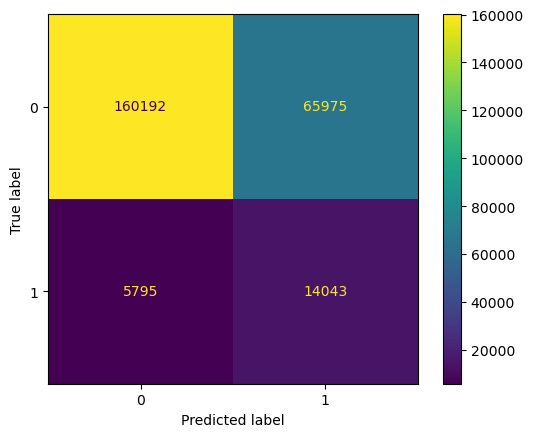

In [26]:
# Looking confusion matrix

predictions = pipe.predict(x_train_processed)
cm = confusion_matrix(y_train, predictions, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
plt.show()

In [27]:
# Compute some scores

accuracy = accuracy_score(y_train, predictions)
f1 = f1_score(y_train, predictions)
precision = precision_score(y_train, predictions)
recall = recall_score(y_train, predictions)

print("Accuracy : {:.2f}".format(accuracy))
print("F1 : {:.2f}".format(f1))
print("Precision : {:.2f}".format(precision))
print("Recall : {:.2f}".format(recall))

Accuracy : 0.71
F1 : 0.28
Precision : 0.18
Recall : 0.71


We will try to increase the recall (detecting the more positive customers possible), thus we need to keep a good accuracy and precision. We will use a metric adapted to our problematic : 
- both false negatives et false positives has a cost for the bank
- a false negative has a high cost because loan won't be repayed
- a false positive has a lower cost but still represents an opportunity cost with the loss of a potential good customer
- the F1 score allows to optimize both precision and recall with the same weight
- we want to give more weight to false negatives, the fbeta_score allows us to do this by setting beta>1

In [28]:
fbeta = fbeta_score(y_train, predictions, beta=2)
print("Fbeta : {:.2f}".format(fbeta))

Fbeta : 0.44


### b. Optimization

#### Gridsearch

In [29]:
# Create a scorer for gridsearch
scorer = make_scorer(fbeta_score, beta=2)

In [36]:
# Optmize parameters

model = LogisticRegression(random_state=random_state, max_iter=10000, 
                           multi_class='ovr', penalty='l2', solver='lbfgs', class_weight='balanced')

param_grid = {
    'C' : np.linspace(0.1, 10, num=10),
}

with timer("Proceed LogisticRegression"):
    LogisticRegression_clf_7 = run_GridSearchCV(model, x_train_processed, y_train, folds, 
                                              param_grid, scorer, balance_class=balance_class)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters on training set :
{'model__C': 0.1}
Best score on training set : 0.433
Proceed LogisticRegression - done in 1232s


#### Processing datas for final model

In [74]:
# Balance training dataset
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.1)
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5)

x_train_over, y_train_over = over.fit_resample(x_train_processed, y_train)
x_train_sampled, y_train_sampled = under.fit_resample(x_train_over, y_train_over)

In [75]:
# Get back the names of columns

# Apply one-hot encoder to each column with categorical data
mode_impute = SimpleImputer(strategy='most_frequent')
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
transformed = mode_impute.fit_transform(x_train[categorical_cols])
transformed = OH_encoder.fit_transform(transformed)
transformed_df = pd.DataFrame(transformed, columns=OH_encoder.get_feature_names_out(input_features=categorical_cols))

# One-hot encoding removed index; put it back
transformed_df.index = x_train.index

# Remove categorical columns (will replace with one-hot encoding)
num_data = x_train.drop(categorical_cols, axis=1)

# Add one-hot encoded columns to numerical features
full_cols = pd.concat([num_data, transformed_df], axis=1)

# Check if we have the right number of features
full_cols.shape[1] == x_train_sampled.shape[1] == x_test_processed.shape[1]

True

In [76]:
# Transforming our matrices in a df with the columns names
x_train_sampled = pd.DataFrame(x_train_sampled, columns=full_cols.columns)
x_test_processed = pd.DataFrame(x_test_processed, columns=full_cols.columns)

#### Fitting final model and selecting threshold

In [77]:
# Best model training

best_C = LogisticRegression_clf_7.best_params_['model__C']

final_model = LogisticRegression(random_state=random_state, max_iter=10000, 
                                 multi_class='ovr', penalty='l2', solver='lbfgs',
                                class_weight='balanced', C = best_C)

with timer("Train model"):
    final_model.fit(x_train_sampled, y_train_sampled)

Train model - done in 19s


In [78]:
# Optimize prediction threshold

test_classification_thresholds(final_model, x_train_sampled, y_train_sampled, threshold_list = np.linspace(0.05, 0.95, num=19))

,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
fbeta,0.716710,0.724671,0.734371,0.743694,0.749632,0.749955,0.741517,0.727662,0.706039,0.672012,0.631135,0.578232,0.512649,0.437568,0.354266,0.257978,0.160022,0.073755,0.014870
accuracy,0.342545,0.375943,0.423373,0.475931,0.528564,0.577895,0.619930,0.658103,0.689188,0.710235,0.727096,0.736779,0.739329,0.735924,0.729321,0.716012,0.698665,0.682187,0.669850
precision,0.336345,0.347573,0.364695,0.385936,0.410122,0.436427,0.462830,0.492347,0.522824,0.550592,0.581784,0.613095,0.643866,0.674076,0.712912,0.750749,0.780709,0.816216,0.833333
recall,0.999204,0.994385,0.983640,0.968031,0.945260,0.914132,0.872922,0.826406,0.773833,0.711222,0.644809,0.570127,0.487796,0.402282,0.314689,0.221613,0.133490,0.060090,0.011938


The fbeta score is maximized at a threshold of 0.3 for prediction, but the accuracy is low. A 0.5 threshold (default value of logistic regression) seems a good trade-off bteween accuracy and recall. We can see we can increase recall by lowering the threshold, but at the expense of lower accuracy : to be determined with the client

## III - Features importance <a class="anchor" id="21-bullet"></a>

### a. Built-in coefficients

In [27]:
# Finding most important variables depending on their coefficients
coefs_importance = pd.DataFrame(final_model.coef_, columns=full_cols.columns)

# Top negatively and positively correlated features
negative_corr = coefs_importance.iloc[0].sort_values()[:10]
positive_corr = coefs_importance.iloc[0].sort_values(ascending=False)[:10]


# All features with absolutes values
coefs_importance_pos = coefs_importance.apply(abs)
best_coefs = coefs_importance_pos.iloc[0].sort_values(ascending=False)[:10]

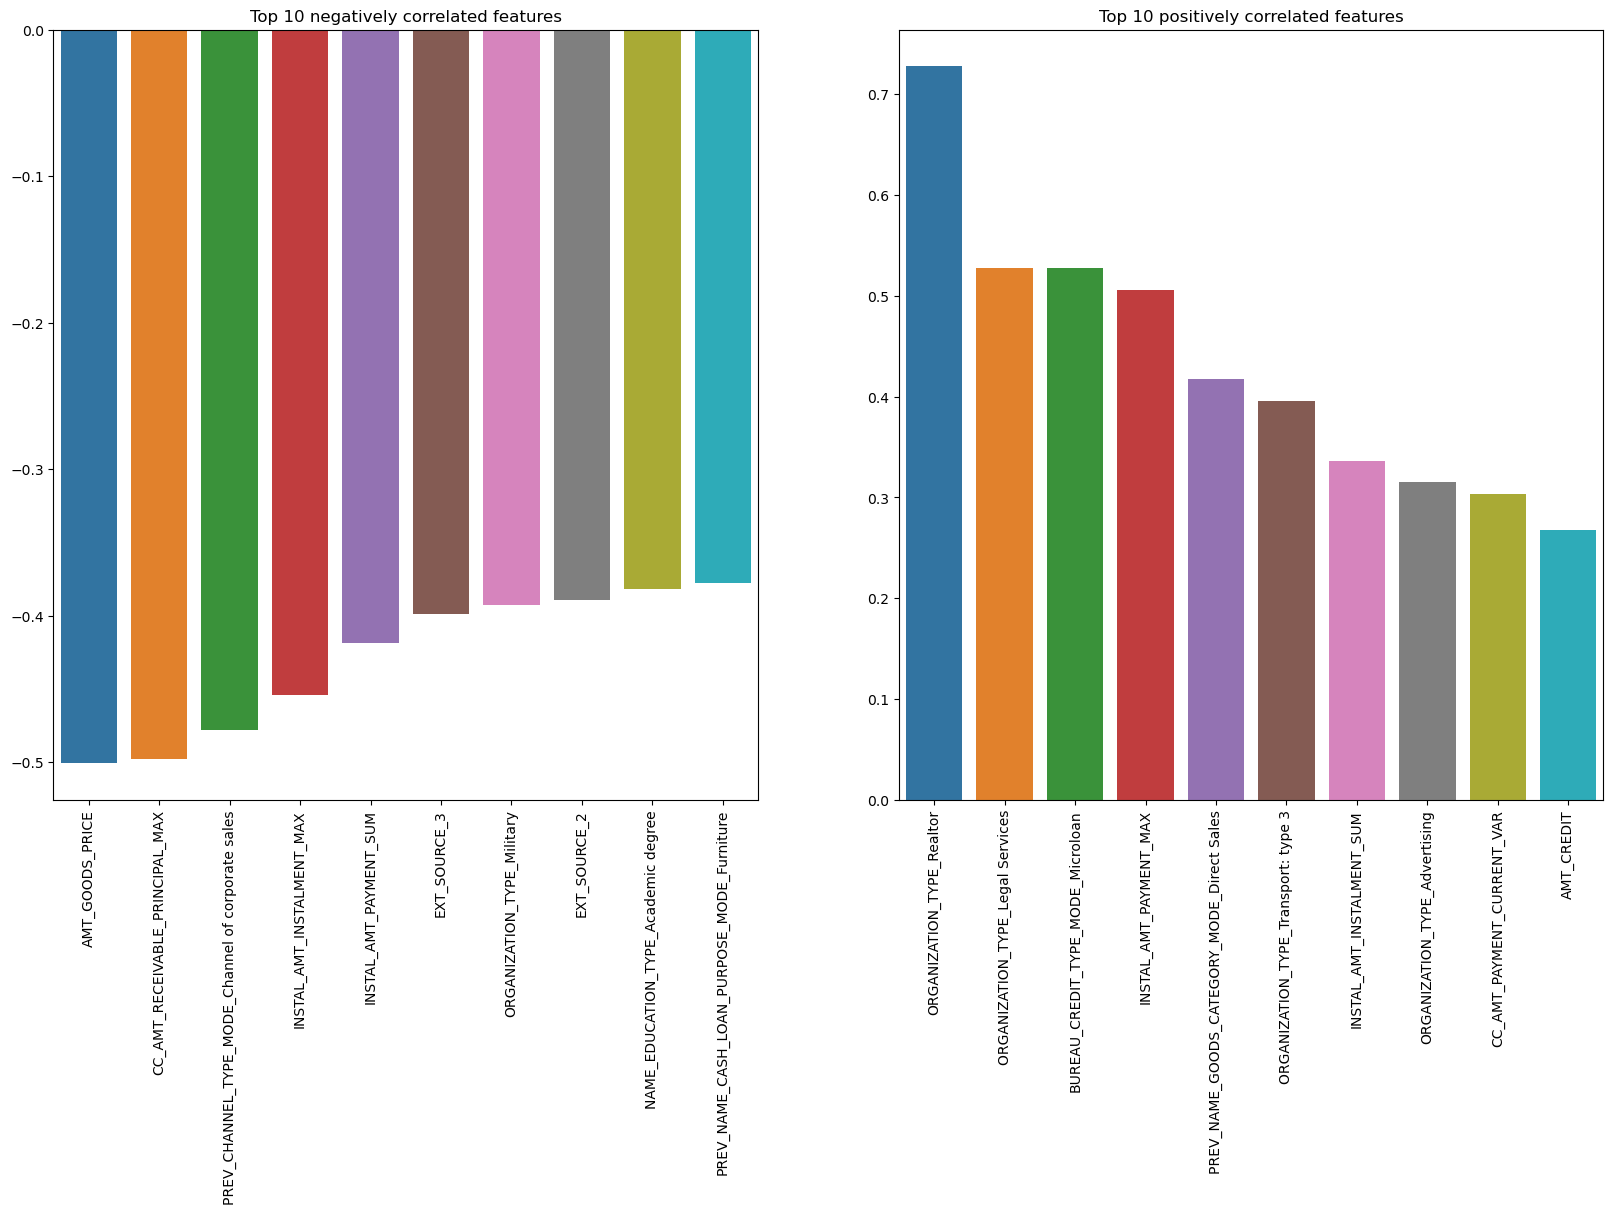

In [28]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.barplot(x=negative_corr.index, y=negative_corr.values)
plt.title('Top 10 negatively correlated features')
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.barplot(x=positive_corr.index, y=positive_corr.values)
plt.title('Top 10 positively correlated features')
plt.xticks(rotation=90)

plt.show()

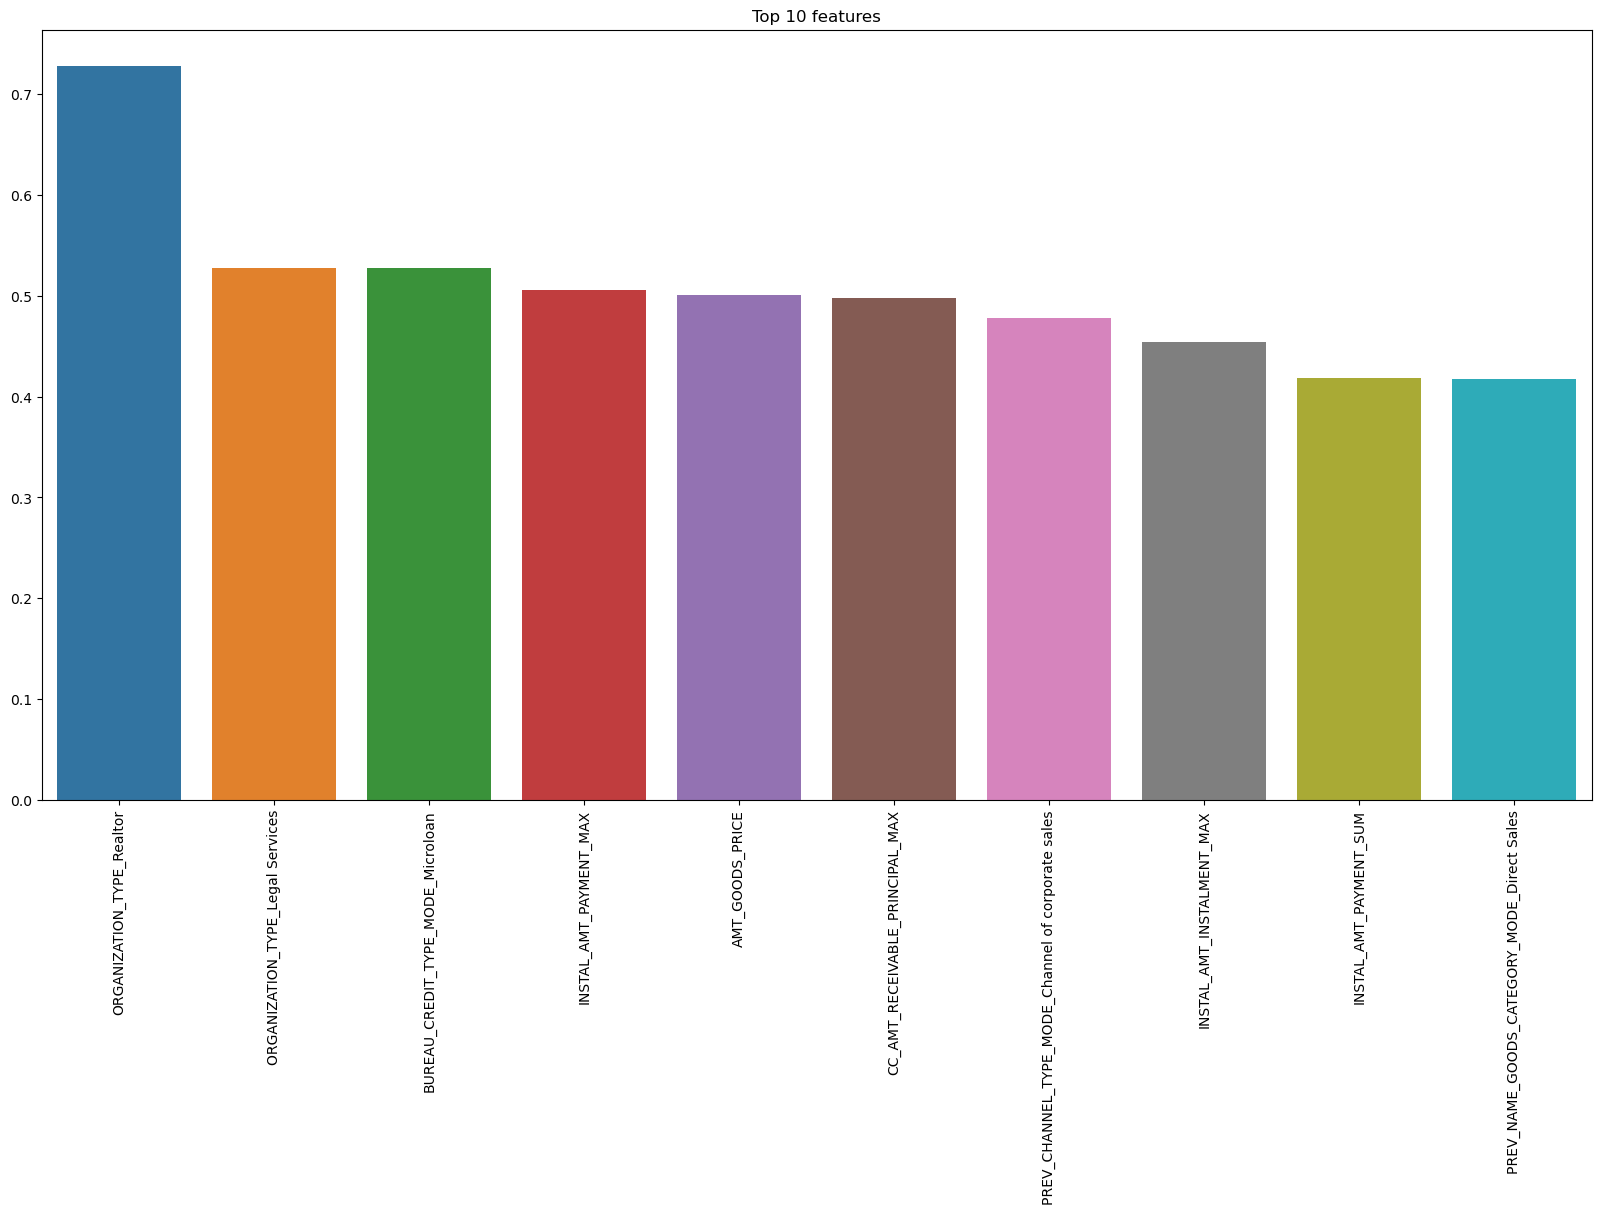

In [29]:
plt.figure(figsize=(20,10))
sns.barplot(x=best_coefs.index, y=best_coefs.values)
plt.title('Top 10 features')
plt.xticks(rotation=90)
plt.show()

### b. Shap : global explanations of features impact

In [79]:
# Create object that can calculate shap values
explainer = shap.LinearExplainer(final_model, x_test_processed)

In [80]:
# Looking difference between shap expected value and mean of train set

print("Mean prediction of model on test set : {:,.2f}".format(final_model.predict(x_test_processed).mean(axis=0)))
print("Shap expected value : {:,.2f}".format(explainer.expected_value))

Mean prediction of model on test set : 0.32
Shap expected value : -0.36


#### Summary plot

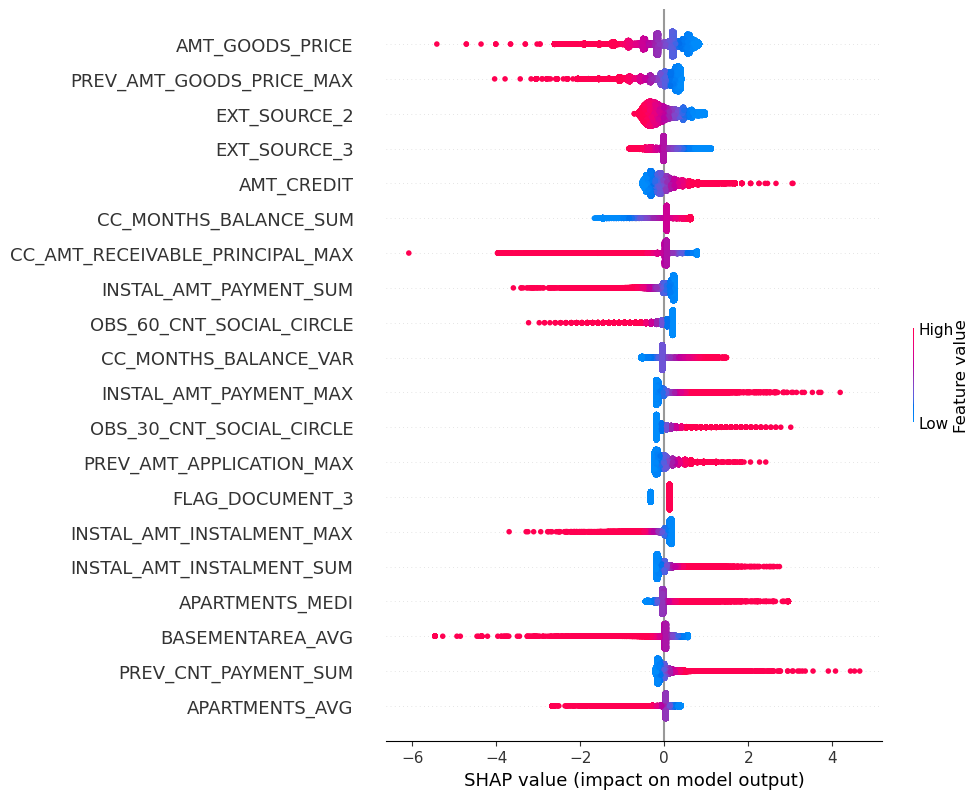

In [81]:
# Dot summary plot
shap_values = explainer.shap_values(x_test_processed)
shap.summary_plot(shap_values, x_test_processed)

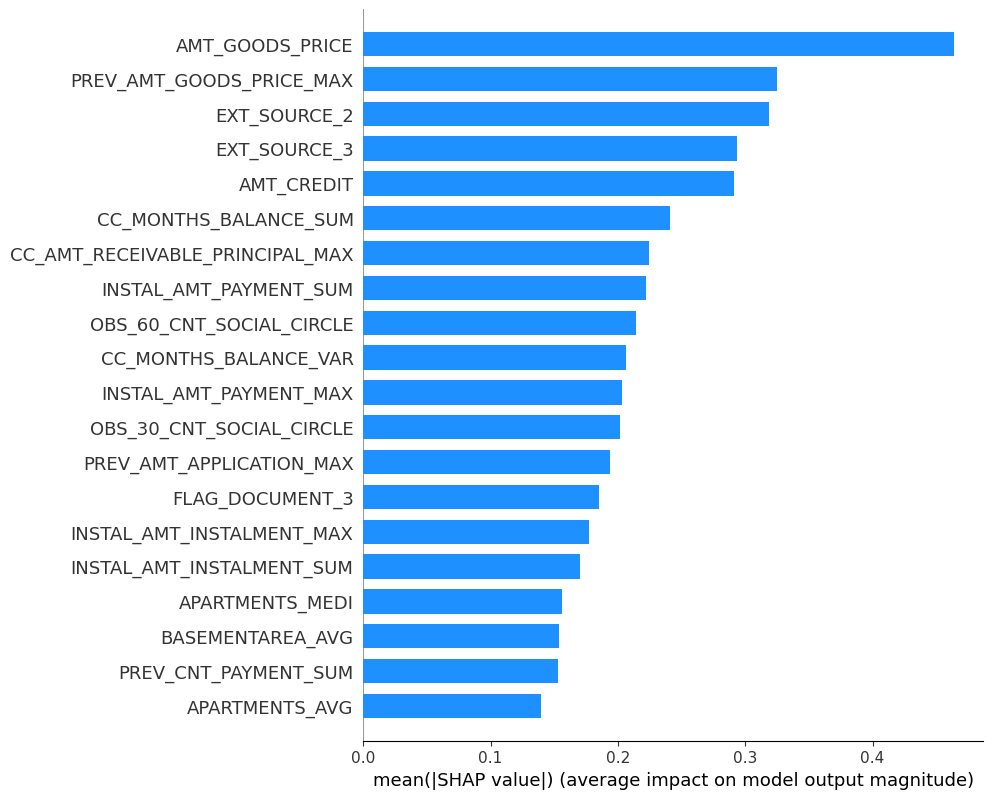

In [82]:
# Bar summary plot
shap.summary_plot(shap_values, x_test_processed, plot_type="bar", color="dodgerblue")

#### Dependance contribution plot

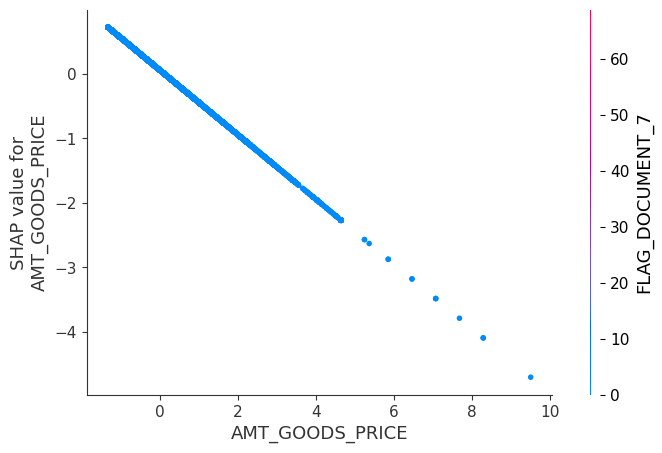

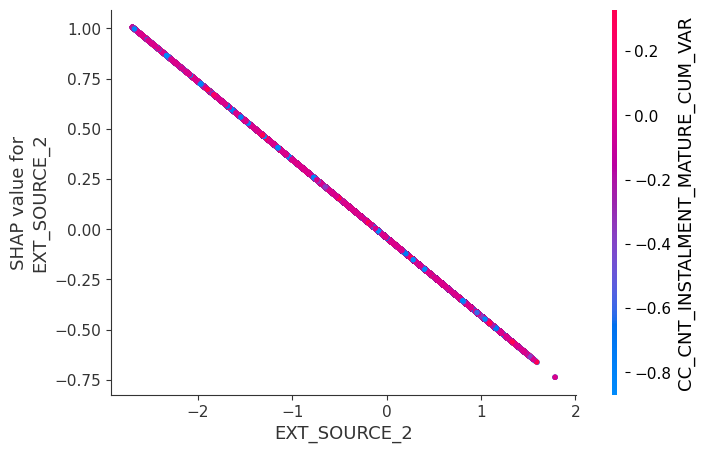

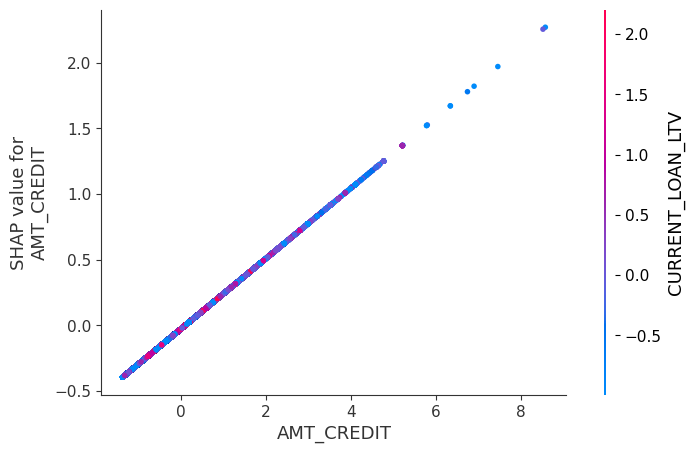

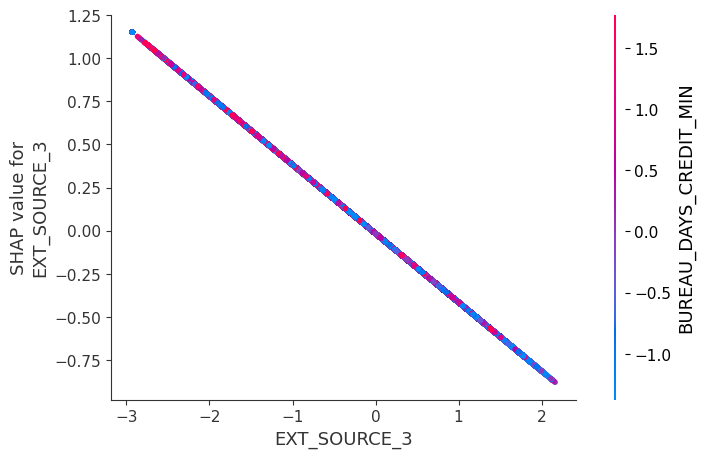

In [34]:
feat_look = ['AMT_GOODS_PRICE', 'EXT_SOURCE_2', 'AMT_CREDIT', 'EXT_SOURCE_3']

# plt.figure(figsize=(20,10))

for i, feat in enumerate(feat_look):
    # plt.subplot(2,2,i+1)
    shap.dependence_plot(feat, shap_values, x_test_processed)
# plt.show()

### d. Shap : local explanations (explanations for one example)

In [131]:
row_to_show = 10
data_for_prediction = x_test_processed.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired


# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [36]:
# Force plot
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

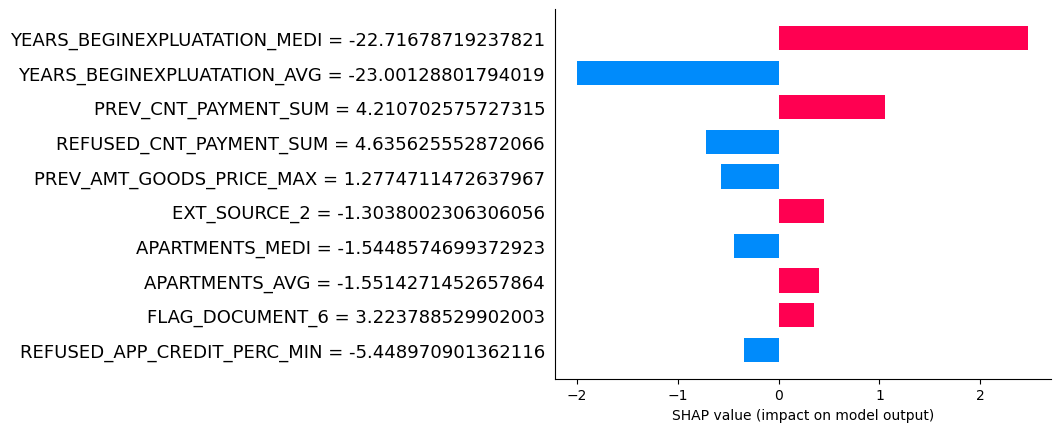

In [147]:
# Bar plot
shap.bar_plot(shap_values, features=data_for_prediction, max_display=10)

## IV - Train on full dataset and save model <a class="anchor" id="22-bullet"></a>

In [39]:
# Preprocessing on full dataset
final_x, final_y = final_preprocessing()

In [41]:
# Best model training on full dataset

best_C = LogisticRegression_clf_7.best_params_['model__C']

selected_model = LogisticRegression(random_state=random_state, max_iter=10000, 
                                 multi_class='ovr', penalty='l2', solver='lbfgs',
                                class_weight='balanced', C = best_C)

with timer("Train model"):
    selected_model.fit(final_x, final_y)

Train model - done in 22s


In [42]:
# Look scores

test_classification_thresholds(selected_model, final_x, final_y, threshold_list = np.linspace(0.05, 0.95, num=19))

,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
fbeta,0.716820,0.724520,0.733306,0.743088,0.748638,0.748926,0.741861,0.727587,0.705392,0.673076,0.629432,0.574626,0.509436,0.436392,0.349844,0.253900,0.160490,0.073618,0.014367
accuracy,0.342932,0.375772,0.421183,0.475072,0.527463,0.575857,0.618980,0.656290,0.687196,0.710261,0.726027,0.735107,0.738361,0.736557,0.727654,0.714412,0.699106,0.682468,0.669827
precision,0.336474,0.347491,0.363742,0.385487,0.409450,0.435128,0.462179,0.490768,0.520717,0.550507,0.580364,0.610721,0.642710,0.677126,0.708818,0.744653,0.785551,0.826829,0.848958
recall,0.999186,0.994198,0.982984,0.967454,0.944177,0.913648,0.874098,0.827402,0.774020,0.712749,0.643024,0.566259,0.484329,0.400771,0.310528,0.217985,0.133862,0.059962,0.011532


In [44]:
# Let's save our model
pickle.dump(selected_model, open('./Models/final_model.pkl', 'wb'))

In [22]:
# We also save descriptions to display it in our API
real_x, real_y = final_preprocessing_2()
descriptions_df = pd.DataFrame(real_x.columns, columns=['Variable'])
descriptions_df['Var_Dataframe'] = descriptions_df['Variable'].apply(find_dataframe)
descriptions_df['Var_Description'] = descriptions_df['Variable'].apply(find_description)
descriptions_df.to_csv('./Clean_datas/var_description.csv')